In [80]:
## Imports
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

from keras.utils.vis_utils import plot_model


## Path

In [3]:
path='/Users/karthik/nlpipe/numpys/'
train_xp=path+'X_train/'
train_yp=path+'y_train/'
test_xp=path+'X_test/'
test_yp=path+'y_test/'
from os import listdir
from os.path import isfile, join
train_xf = [f for f in listdir(train_xp) if isfile(join(train_xp, f))]
train_yf = [f for f in listdir(train_yp) if isfile(join(train_yp, f))]
test_xf = [f for f in listdir(test_xp) if isfile(join(test_xp, f))]
test_yf = [f for f in listdir(test_yp) if isfile(join(train_yp, f))]
train_x=[]
train_y=[]
test_x=[]
test_y=[]
for i,f in enumerate(train_xf):
    try:
        x=np.load(train_xp+f)
        y=np.load(train_yp+f).astype(np.float32)
        train_x.append(x)
        train_y.append(y)
    except ValueError:
        print('file format')
testing=[]
for i,f in enumerate(test_xf):
    try:
        x=np.load(test_xp+f)
        y=np.load(test_yp+f).astype(np.float32)
        test_x.append(x)
        test_y.append(y)
    except ValueError:
        print('file format')

file format


In [4]:
test_x[0][:,:,1].shape

(560, 640)

## Data Generator

In [27]:
from torch.utils.data import Dataset,DataLoader
class Dataload(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def __getitem__(self,i):
        return self.x[i],self.y[i]
    def __len__(self):
        return len(self.x)
class DataGen(keras.utils.Sequence):
    def __init__(self, x, y, batch_size=5, h=560,w= 640):
        self.ids = list(range(len(x)))
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.h = h
        self.h = w
        self.on_epoch_end()
        
    def __load__(self, id_name):
        
        ## Reading Image
        image = self.x
        
        ##Reading Mask
        mask = self.y
        
        ## Normalizaing 
        
        return image[id_name], mask[id_name]
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [28]:
len(train_x[190:])

17

In [29]:
data=DataGen(train_x[:190],train_y[:190])
vdata=DataGen(train_x[190:],train_y[190:])


In [47]:
test=DataGen(test_x,test_y)

In [55]:
test.__getitem__(1)[0].shape

(5, 560, 640, 3)

## Hyperparameters

In [31]:
x, y = data[0]
print(x.shape, y.shape)

(5, 560, 640, 3) (5, 560, 640, 3)


## Different Blocks

In [105]:
def batch_norm(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_unit(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batch_norm(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def ini(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_unit(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    short = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    short = batch_norm(short, act=False)
    output = keras.layers.Add()([conv, short])
    return output

def residual_unit(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_unit(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_unit(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    short = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    short = batch_norm(short, act=False)
    output = keras.layers.Add()([short, res])
    return output

def up_concat_unit(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

## ResUNet

In [108]:
def ResUNet():
    f = [8, 16 ,32]
    inputs = keras.layers.Input((None,None, 3))
    
    ## Encoder
    e0 = inputs
    e1 = ini(e0, f[0])
    e2 = residual_unit(e1, f[1], strides=2)
    e3 = residual_unit(e2, f[2], strides=2)
    
    ## Bridge
    b0 = conv_unit(e3, f[2], strides=1)
    b1 = conv_unit(b0, f[2], strides=1)
    
    ## Decoder
    u1 = up_concat_unit(b1, e2)
    d1 = residual_unit(u1, f[2])
    
    u2 = up_concat_unit(d1, e1)
    d2 = residual_unit(u2, f[1])
    
    outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation="sigmoid")(d2)
    model = keras.models.Model(inputs, outputs)
    return model

In [112]:
smooth = 1.

def dice_coefficient(y_true, y_pred):
    y_true_f = tf.compat.v1.layers.flatten(y_true)
    y_pred_f = tf.compat.v1.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_coefficient= (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice_coefficient


def dice_coefficient_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)
def iou_loss(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return -1*(tf.keras.backend.sum(intersection, axis=-1) + tf.keras.backend.epsilon()) / (tf.keras.backend.sum(union, axis=-1) + tf.keras.backend.epsilon())

In [38]:
def build_iou_for(label: int, name: str=None):
    """
    Build an Intersection over Union (IoU) metric for a label.
    Args:
        label: the label to build the IoU metric for
        name: an optional name for debugging the built method
    Returns:
        a keras metric to evaluate IoU for the given label
        
    Note:
        label and name support list inputs for multiple labels
    """
    # handle recursive inputs (e.g. a list of labels and names)
    if isinstance(label, list):
        if isinstance(name, list):
            return [build_iou_for(l, n) for (l, n) in zip(label, name)]
        return [build_iou_for(l) for l in label]

    # build the method for returning the IoU of the given label
    def label_iou(y_true, y_pred):
        """
        Return the Intersection over Union (IoU) score for {0}.
        Args:
            y_true: the expected y values as a one-hot
            y_pred: the predicted y values as a one-hot or softmax output
        Returns:
            the scalar IoU value for the given label ({0})
        """.format(label)
        return iou(y_true, y_pred, label)

    # if no name is provided, us the label
    if name is None:
        name = label
    # change the name of the method for debugging
    label_iou.__name__ = 'iou_{}'.format(name)

    return label_iou

In [39]:
def iou(y_true, y_pred, label: int):
    """
    Return the Intersection over Union (IoU) for a given label.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        label: the label to return the IoU for
    Returns:
        the IoU for the given label
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = tf.keras.backend.cast(tf.keras.backend.equal(tf.keras.backend.argmax(y_true), label), tf.keras.backend.floatx())
    y_pred = tf.keras.backend.cast(tf.keras.backend.equal(tf.keras.backend.argmax(y_pred), label), tf.keras.backend.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = tf.keras.backend.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    # avoid divide by zero - if the union is zero, return 1
    # otherwise, return the intersection over union
    return tf.keras.backend.switch(tf.keras.backend.equal(union, 0), 1.0, intersection / union)

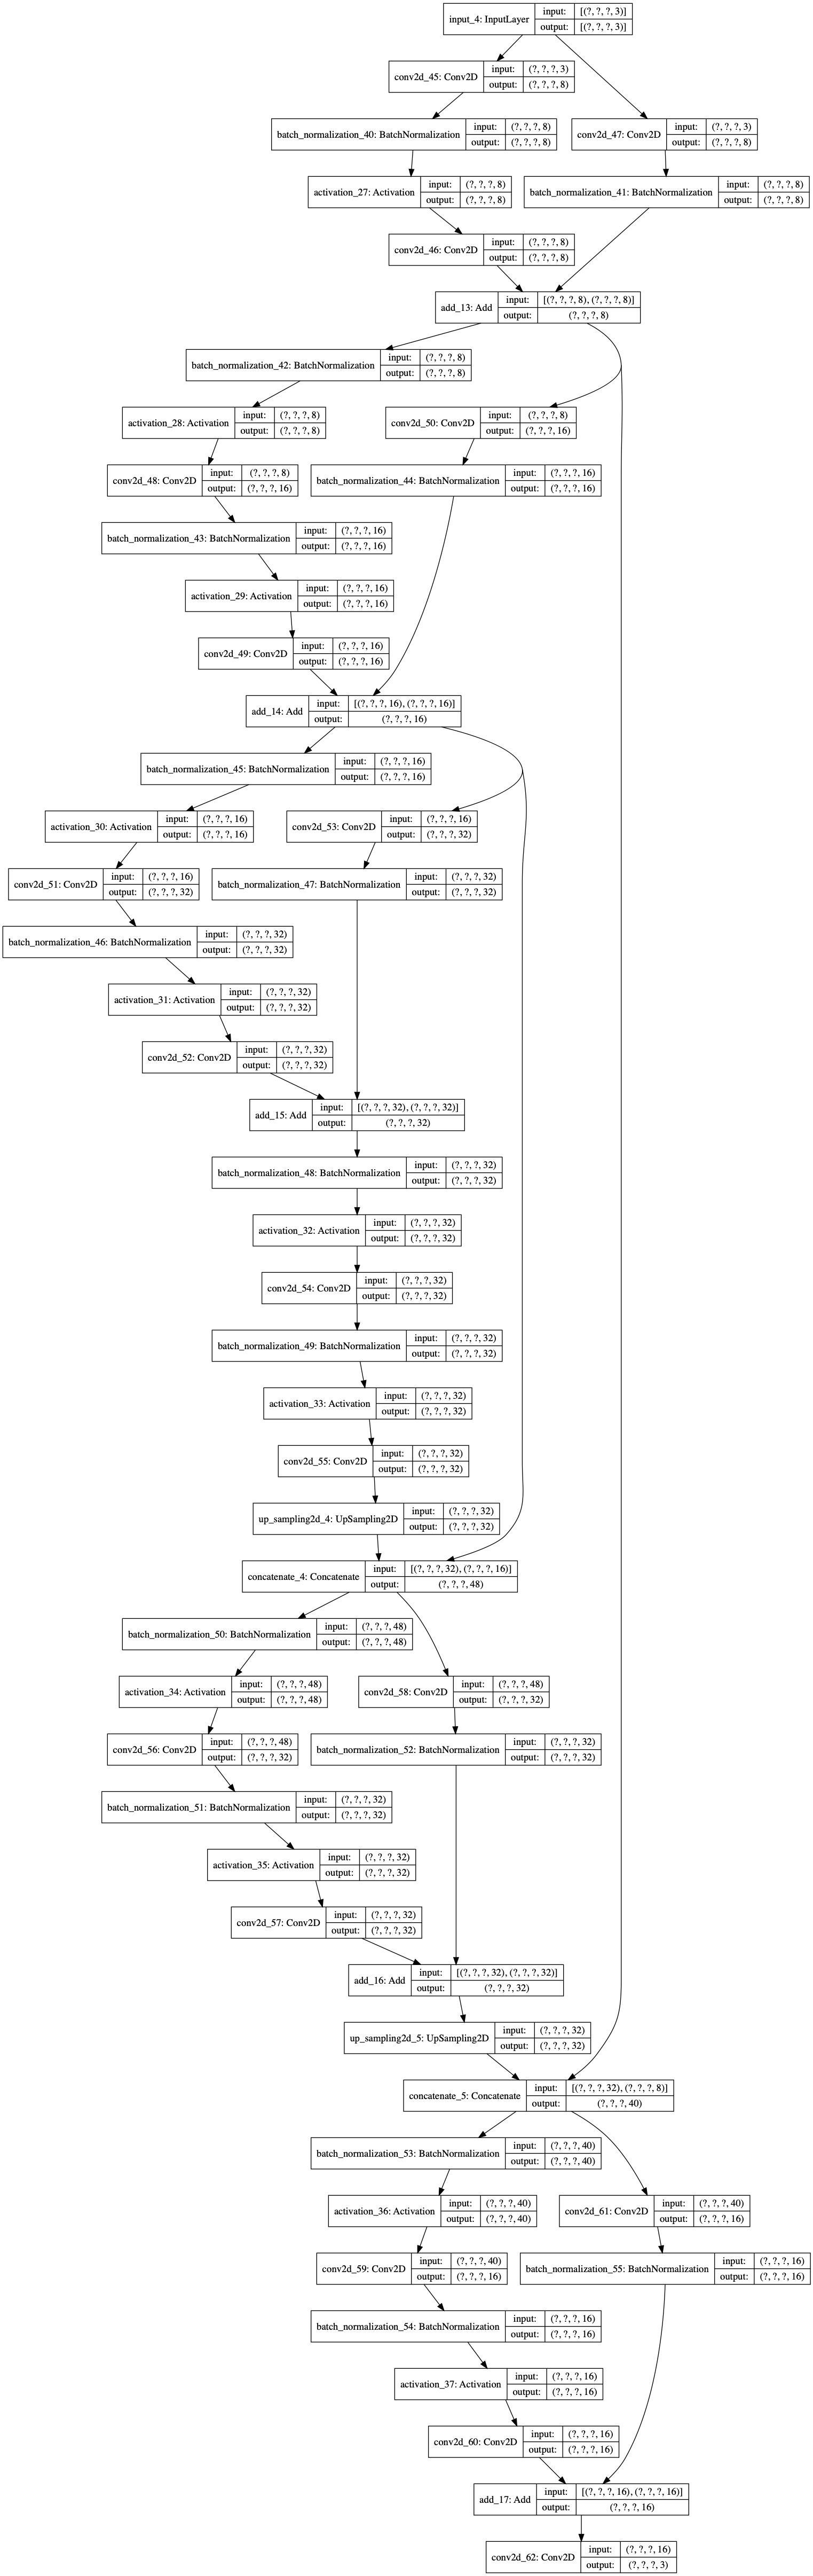

In [109]:
model = ResUNet()
adam = keras.optimizers.Adam()
loss    = tf.keras.losses.categorical_crossentropy
metrics = [ iou_loss, build_iou_for(label=1) ] 
model.compile(optimizer=adam, loss= loss,metrics=metrics)
plot_model(model,show_shapes=True, show_layer_names=True)

## Training

In [42]:
#train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
#valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
batch_size=5

epochs = 20


model.fit_generator(data, validation_data=vdata, 
                    epochs=epochs)

Epoch 1/20
38/38 [==============================] - 219s 6s/step - loss: 0.3157 - iou_loss: -0.7236 - iou_1: 0.1406 - val_loss: 0.6290 - val_iou_loss: -0.6148 - val_iou_1: 0.1525
Epoch 2/20
38/38 [==============================] - 222s 6s/step - loss: 0.1063 - iou_loss: -0.9087 - iou_1: 0.1029 - val_loss: 0.2872 - val_iou_loss: -0.8314 - val_iou_1: 0.2352
Epoch 3/20
38/38 [==============================] - 216s 6s/step - loss: 0.0934 - iou_loss: -0.9186 - iou_1: 0.1062 - val_loss: 0.1299 - val_iou_loss: -0.9045 - val_iou_1: 0.2518
Epoch 4/20
38/38 [==============================] - 217s 6s/step - loss: 0.0867 - iou_loss: -0.9209 - iou_1: 0.0699 - val_loss: 0.0997 - val_iou_loss: -0.9324 - val_iou_1: 0.0057
Epoch 5/20
38/38 [==============================] - 216s 6s/step - loss: 0.0800 - iou_loss: -0.9239 - iou_1: 0.0441 - val_loss: 0.1075 - val_iou_loss: -0.9196 - val_iou_1: 0.0680
Epoch 6/20
38/38 [==============================] - 217s 6s/step - loss: 0.0783 - iou_loss: -0.9236 - iou

In [43]:
model.save_weights("ResUNet.h5")


   Ground Truth   Predicted Value   Input Img


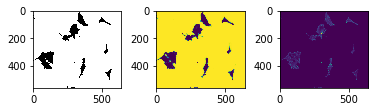

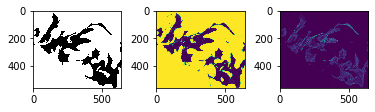

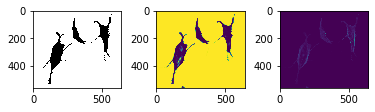

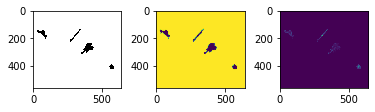

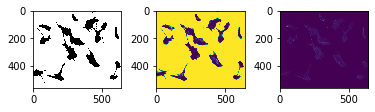

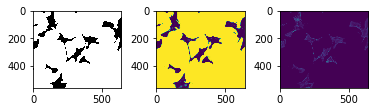

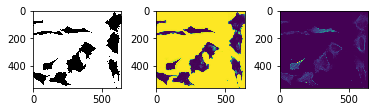

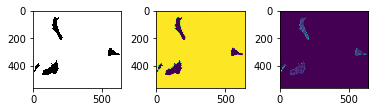

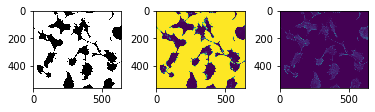

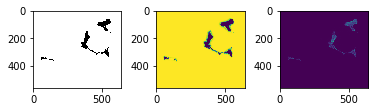

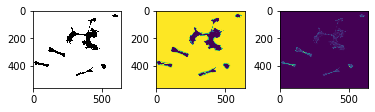

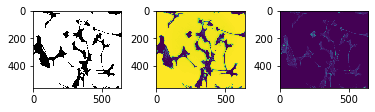

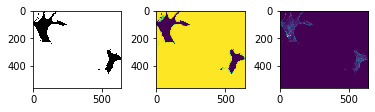

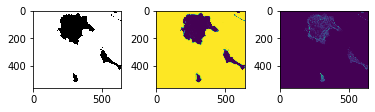

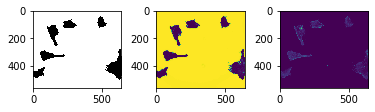

In [104]:
print("\n   Ground Truth   Predicted Value   Input Img")
loss=[]
for i in range(1, 4, 1):
    x, y = test.__getitem__(i)
    result = model.predict(x)
    c=0
    for i in range(len(result)):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(y[i,:,:,c], cmap="gray")

        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(result[i,:,:,c], interpolation='nearest')
        
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.asarray(x[i,:,:,c],dtype='int'),interpolation='nearest')

In [64]:
np.mean(y[i,:,:,1]-result[i,:,:,2])

0.060758352

In [68]:
iou(y,result,2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7275603>

In [235]:
result.shape

(4, 560, 640, 3)

In [110]:
def iou_loss(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)
    intersection=intersection.flatten()
    union=union.flatten()
    return (tf.keras.backend.sum(intersection, axis=-1) + tf.keras.backend.epsilon()) / (tf.keras.backend.sum(union, axis=-1) + tf.keras.backend.epsilon())
iou_loss(y,result)

<tf.Tensor: shape=(), dtype=float32, numpy=0.931952>

In [113]:
dice_coefficient(y,result)

<tf.Tensor: shape=(), dtype=float32, numpy=0.96477765>